In [ ]:
!pip install pandas
!pip install matplotlib

In [111]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

conn = sqlite3.connect('student_grades.db')
cursor = conn.cursor()

In [112]:
# for clearing/testing
# cursor.execute('DROP TABLE IF EXISTS grades')
# cursor.execute('DROP TABLE IF EXISTS students')


In [113]:

cursor.execute('''
    CREATE TABLE students (
    student_id INTEGER PRIMARY KEY AUTOINCREMENT, 
    first_name TEXT,
    last_name TEXT
    )
''')

cursor.execute('''
    CREATE TABLE grades (
    grade_id INTEGER PRIMARY KEY AUTOINCREMENT,
    student_id INTEGER,
    subject TEXT,
    grade INTEGER,
    FOREIGN KEY (student_id) REFERENCES students(student_id)
    )
''')

cursor.executemany('INSERT INTO students (first_name, last_name) VALUES (?, ?)',
                   [
                       ('Alice', 'Johnson'),
                       ('Bob', 'Smith'),
                       ('Carol', 'White'),
                       ('David', 'Brown'),
                       ('Eve', 'Davis')
                   ])

grades_list = [
    (1, 'Math', 95),
    (1, 'English', 88),
    (1, 'History', 90),
    (2, 'Math', 82),
    (2, 'English', 76),
    (2, 'History', 85),
    (3, 'Math', 100),
    (3, 'English', 91),
    (3, 'History', 85),
    (4, 'Math', 92),
    (4, 'English', 100),
    (4, 'History', 10),
    (5, 'Math', 45),
    (5, 'English', 19),
    (5, 'History', 87)]

cursor.executemany('INSERT INTO grades (student_id, subject, grade) VALUES (?, ?, ?)', grades_list)

conn.commit()

In [114]:
# retrieve all students' names and their grades
pd.read_sql_query(
    '''
    SELECT students.first_name, students.last_name, grades.subject, grades.grade
    FROM students
    JOIN grades ON students.student_id = grades.student_id;
    '''
, conn)

,first_name,last_name,subject,grade
0,Alice,Johnson,Math,95
1,Alice,Johnson,English,88
2,Alice,Johnson,History,90
3,Bob,Smith,Math,82
4,Bob,Smith,English,76
5,Bob,Smith,History,85
6,Carol,White,Math,100
7,Carol,White,English,91
8,Carol,White,History,85
9,David,Brown,Math,92


In [115]:
# find the average grade for each student
pd.read_sql_query(
    '''
    SELECT students.first_name, students.last_name, AVG(grades.grade) AS average_grade
    FROM students
    JOIN grades ON students.student_id = grades.student_id
    GROUP BY students.student_id;
    ''' 
, conn)

,first_name,last_name,average_grade
0,Alice,Johnson,91.000000
1,Bob,Smith,81.000000
2,Carol,White,92.000000
3,David,Brown,67.333333
4,Eve,Davis,50.333333


In [116]:
# find the student with the highest average grade
pd.read_sql_query(
     '''
    SELECT students.first_name, students.last_name, AVG(grades.grade) AS average_grade
    FROM students
    JOIN grades ON students.student_id = grades.student_id
    GROUP BY students.student_id
    ORDER BY average_grade DESC
    LIMIT 1;
    '''
, conn)

,first_name,last_name,average_grade
0,Carol,White,92.0


In [117]:
# find the average grade for the Math subject
pd.read_sql_query(
    '''
    SELECT AVG(grades.grade) AS average_math_grade
    FROM grades
    WHERE grades.subject = 'Math';
    '''
, conn)

,average_math_grade
0,82.8


In [118]:
# list all students who scored above 90 in any subject
pd.read_sql_query(
    '''
    SELECT DISTINCT students.first_name, students.last_name
    FROM students
    JOIN grades ON students.student_id = grades.student_id
    WHERE grades.grade > 90;
    '''
, conn)

,first_name,last_name
0,Alice,Johnson
1,Carol,White
2,David,Brown


In [119]:
#  load the data from the students and grades tables into DataFrames
students_dataframe = pd.read_sql_query("SELECT * FROM students", conn)
grades_dataframe = pd.read_sql_query("SELECT * FROM grades", conn)

In [120]:
# combined_query
combined = pd.read_sql_query(
    '''
    SELECT students.first_name, students.last_name, grades.subject, grades.grade
    FROM students
    JOIN grades ON students.student_id = grades.student_id;
    ''' 
, conn)

Text(0.5, 0, 'Student')

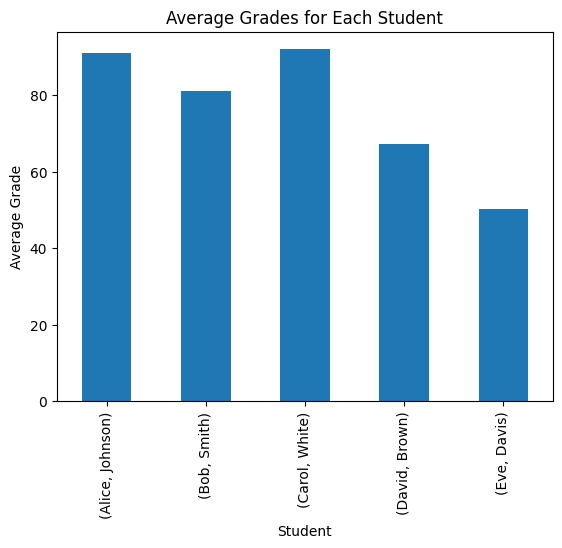

In [121]:
# plot the average grades for each student
(combined.groupby(['first_name', 'last_name'])['grade'].mean()).plot(kind='bar', title='Average Grades for Each Student')
plt.ylabel('Average Grade')
plt.xlabel('Student')

(array([0, 1, 2]),
 [Text(0, 0, 'English'), Text(1, 0, 'History'), Text(2, 0, 'Math')])

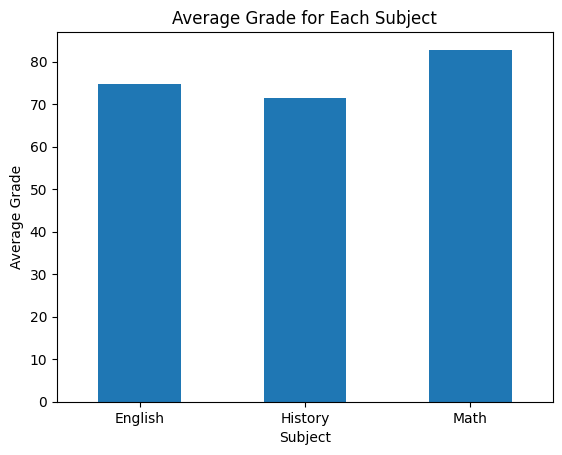

In [122]:
# create a bar chart showing the average grade for each subject
(combined.groupby('subject')['grade'].mean()).plot(kind='bar', title='Average Grade for Each Subject')
plt.ylabel('Average Grade')
plt.xlabel('Subject')
plt.xticks(rotation=0)

Text(0.5, 0, 'Subject')

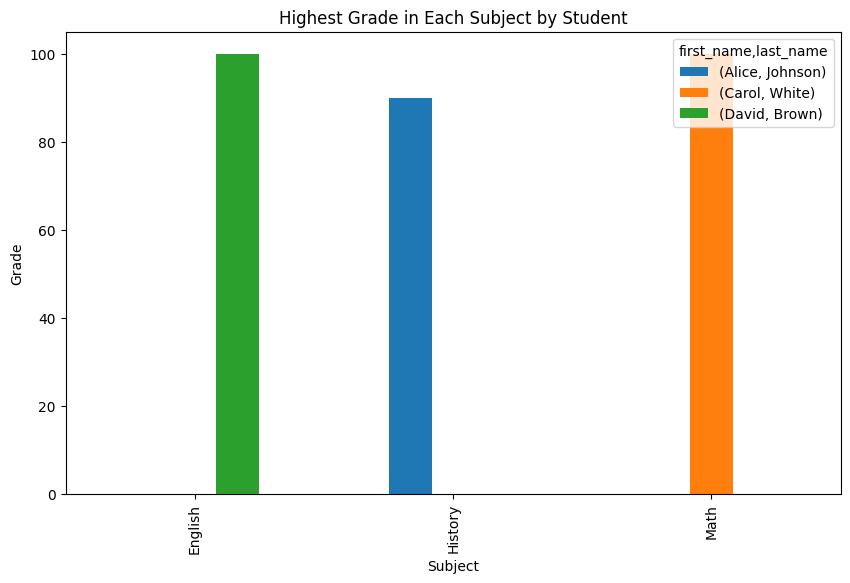

In [123]:
# BONUS QUESTION

highest_grade_query = '''
    SELECT students.first_name, students.last_name, grades.subject, grades.grade
    FROM students
    JOIN grades ON students.student_id = grades.student_id
    WHERE (grades.subject, grades.grade) IN (
    SELECT subject, MAX(grade)
    FROM grades
    GROUP BY subject
    );
'''
corrected = pd.read_sql_query(highest_grade_query, conn).pivot(index='subject', columns=['first_name', 'last_name'], values='grade')
corrected.plot(kind='bar', figsize=(10, 6), title='Highest Grade in Each Subject by Student')
plt.ylabel('Grade')
plt.xlabel('Subject')